In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
def PrepData(pathfile,carmodelname,target): ##remove nulls in price
    df = pd.read_csv(pathfile)
    df = df[df['model_name'].isin([carmodelname])].reset_index(drop=True).drop(['feature_1','feature_2','feature_3','feature_4','feature_5','feature_6','feature_7','feature_8','feature_9','duration_listed','engine_has_gas','engine_type','has_warranty','is_exchangeable','location_region','number_of_photos','body_type','up_counter','feature_0','manufacturer_name','model_name'],axis=1)
    TargetVar = df[target]
    df.drop(columns=[target], axis=1,inplace=True)
    df.insert(0,target, TargetVar)
    dfobject = df.select_dtypes(include='object')
    df = df.select_dtypes(exclude='object')
    return dfobject, df

def Dummies(df):
    return pd.concat([df, pd.get_dummies(df[list(df)])],axis=1).drop(df[list(df)],axis=1)

def ReadyData(df1,df2):
    return pd.merge(df1,Dummies(df2),left_index=True,right_index=True)

In [3]:
def BoxplotObjects(df,dftarget): ## Show counts on plot
    fig, axs = plt.subplots(ncols=len(list(df)), figsize=(30,6),sharey=True)
    t = 0
    for x in list(df):
        sns.boxplot(x=df[x],y=dftarget[Y],data=df, ax=axs[t])
        t += 1
    return

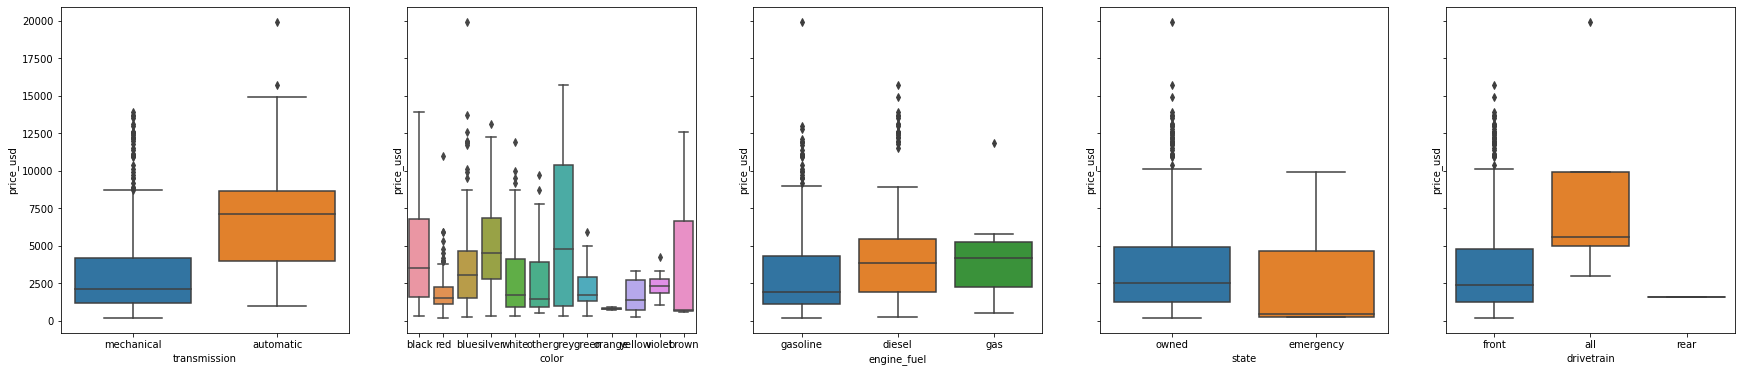

In [4]:
pf = 'C:/Users/Gfreitas/Downloads/ModeloPreditivoCarrosUsados/cars.csv' #pathfile of the dataset
carmodel = 'Golf' # Car model to predict
Y = 'price_usd' # Y is the name of the column with dependent (target) variable
dfobj, dfnum = PrepData(pf,carmodel,Y)
BoxplotObjects(dfobj, dfnum)
cardf = ReadyData(dfnum, dfobj)

In [5]:
#Vamos Analisar a significância estatística das variáveis em comparação com o preço (price_usd).
#Neste projeto, p < 0.05 é definido como estatisticamente significante, ou seja, uma confiança de >95% de que a correlação entre os dados é significante, e não uma coincidência.
#Pipeline?
def CoefPearson(df):
    lcoef = []
    lp = []
    for x in list(df.columns):
        coef, p = stats.pearsonr(df[x],df[Y])
        lcoef.append(coef)
        lp.append(round(p,3))
    return pd.DataFrame(lcoef).merge(pd.DataFrame(lp),on=df.columns).rename(columns={'key_0':'IndependentVar','0_x':'PearsonCoef','0_y':'P-Value'}).drop([0]).reset_index(drop=True)

def FilterP(df,plimit):
    return df[df['P-Value'] <= plimit].reset_index(drop=True)

def ListP(df,plimit):   # MLR variable list (filter n biggest))
    return list(FilterP(df,plimit)['IndependentVar'])

def ListMaxAbsCoef(df,plimit): #PR and SLR variable list
    df = FilterP(df,plimit)
    return list(df.loc[df['PearsonCoef'].abs().idxmax()])

Simple Linear Regression Model Equation:
 -687740.0671526314 + 346.0436035430563 * price_usd


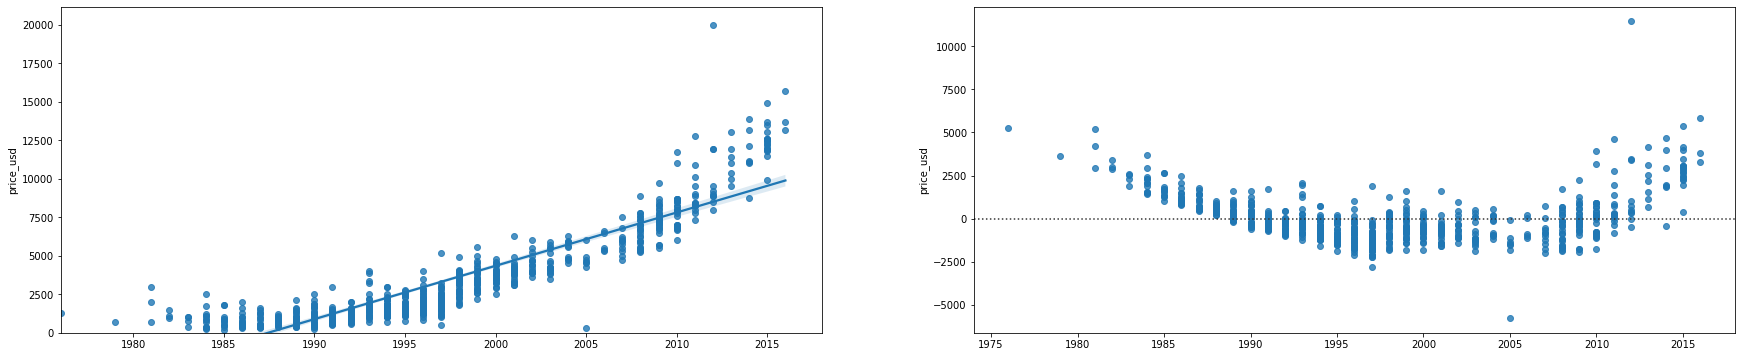

In [6]:
#Simple Linear Regression + Residual Plot
##Create plot function
BestIndVar = ListMaxAbsCoef(CoefPearson(cardf),0.05)
TargetVar = cardf[Y]
lm = LinearRegression()
X = cardf[[BestIndVar[0]]].values
lm.fit(X,TargetVar)
fig, axs = plt.subplots(ncols=2, figsize=(30,6))
ax0 = sns.regplot(x=X,y=TargetVar,data=cardf,ax=axs[0])
ax1 = sns.residplot(x=X,y=TargetVar,data=cardf,ax=axs[1])
ax0.set_ylim(0,)
ax0.set_xlim(X.min(),)
print('Simple Linear Regression Model Equation:\n',lm.intercept_,'+',float(lm.coef_),'*',Y)
#Residual plot shows that linear regression is not a good model (curvy residual)

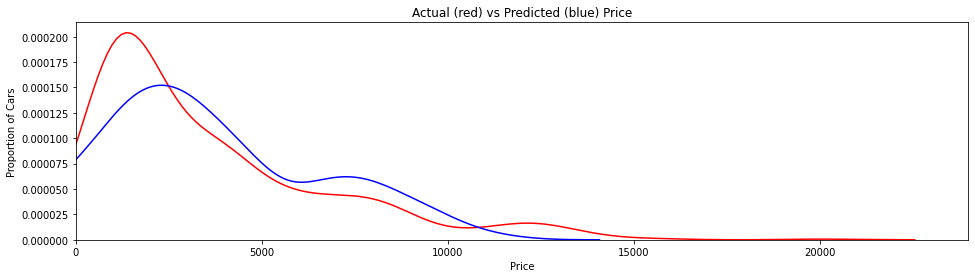

Intercept: -630565.3149226797
Coefs: [-0.0003170814503313186, 318.94396060375624, -1178.005760944823, 426.3759665854557, -426.37596658545783, 228.33381167292768, -97.81654735937887, 898.1080795880218, -166.67513906193707, -199.7386030585114, -134.49567191730236, 715.2565320325081, 102.36729614906815, 2290.7657913387434, -1026.1180113779137]


In [7]:
#Regressão Linear Múltipla
##better show coef and intercept (table?)
lm1 = LinearRegression()
Z = cardf[ListP(CoefPearson(cardf),0.05)].values #Z is the selection of independent variable columns
lm1.fit(Z,TargetVar)
##Create plot function
plt.figure(figsize=(16,4))
ax1 = sns.kdeplot(TargetVar, color="r", label="Actual Value")
sns.kdeplot(lm1.predict(Z), color="b", label="Predicted Values", ax=ax1)
plt.title('Actual (red) vs Predicted (blue) Price')
plt.xlabel('Price')
plt.ylabel('Proportion of Cars')
plt.xlim(0,)
plt.show()
plt.close()
print("Intercept:",lm1.intercept_)
print("Coefs:",list(lm1.coef_))

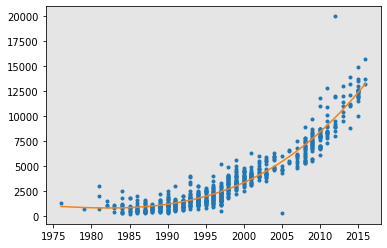

Polynomial Regression Model Equation:
         3        2
0.1785 x - 1056 x + 2.084e+06 x - 1.371e+09


In [8]:
#Polynomial Regression Plotting
def PlotPR(model, X, Y):
    x_new = np.linspace(X.min(),X.max())
    y_new = model(x_new)
    plt.plot(X, TargetVar, '.', x_new, y_new, '-')
    ax = plt.gca()
    ax.set_facecolor((0.898, 0.898, 0.898))
    fig = plt.gcf()
    plt.show()
    plt.close()
x = cardf[BestIndVar[0]].values
p = np.poly1d(np.polyfit(x, TargetVar, 3)) #3 degrees polynomial. Adjust to be selectable and be ready for hyperparameters
PlotPR(p, x, TargetVar)
print('Polynomial Regression Model Equation:\n',p)

In [9]:
def R2andMSE(realY,predictY):
    print('R2:',r2_score(realY,predictY))
    print('MSE:',mean_squared_error(realY, predictY))
    return

def SLR_Pred(model,independent_variable):
    return round((float(model.predict([[independent_variable]]))),2)

def MLR_Pred(model,independent_variable):
    return round(float(model.predict([independent_variable])),2)

def PR_Pred(model,independent_variable): #adapt to get any polinomial
    return round(model(independent_variable),2)

In [10]:
##Adapt to compare models and select the best with MSE or r2 (user choice)
##show as table?
print('SLR R2 and MSE:')
R2andMSE(TargetVar,lm.predict(X))
print('MLR R2 and MSE:')
R2andMSE(TargetVar,lm1.predict(Z))
print('RP R2 and MSE:')
R2andMSE(TargetVar,p(x))

SLR R2 and MSE:
R2: 0.8134058215471239
MSE: 1917327.5345821206
MLR R2 and MSE:
R2: 0.8378731807182898
MSE: 1665915.9319997057
RP R2 and MSE:
R2: 0.9202584402467222
MSE: 819375.4458641758


In [11]:
#Predições
MLR_Var = [120000,2010,2.5,1,0,1,0,0,0,0,0,0,1,0,1]#get it from user input, showing the independent variables names
Var = 2010
print('SLR predicted price:',SLR_Pred(lm,Var))
print('MLR predicted price:',MLR_Pred(lm1,MLR_Var))
print('RP predicted price:',PR_Pred(p,Var))

SLR predicted price: 7807.58
MLR predicted price: 7259.94
RP predicted price: 8356.24


In [12]:
#Teste de ANOVA (Analise de Variância)
#O teste de ANOVA testa a significância da variação das médias entre grupos de uma mesma variável.
#Dois parâmetros são observados no teste ANOVA: Teste_F e Valor_P.
#Teste_F: ANOVA assume que a hipótese que a média entre os grupos é a mesma, e quantifica o desvio da média calculada pela média assumida. Quanto maior o Teste_F, maior a diferença entre médias.
#Valor_P: Indica o quão estatisticamente significante é o valor de Teste_F.
###move price column to end and remove from loop
#def Anova(df):
#    for x in list(df.columns):
#        f_val, p_val = stats.f_oneway(df[x],TargetVar)
#        print("ANOVA",x,"x Price: F-Value=", round(f_val,2),"P-Value:", round(p_val,2))
#    return 

#compare in groups of same variable
#Anova(cardf)
#grp_year_produced=vwjetta_df[['year_produced', 'price_usd']].groupby(['year_produced'])
#grp_year_produced.head()
#obsolete multiplication of 2 lists: round((sum([a * b for a, b in zip(independent_variable, model.coef_)])+model.intercept_),2)
#cardf.info()
#cardf.describe()
#cardf.corr()